In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# 1. BIDS data format

In [3]:
dDIR= '../../../datasets/sdc_bids_fmri/data/ds000030/derivatives/fmriprep/'
!tree -L 1 $dDIR

../../../datasets/sdc_bids_fmri/data/ds000030/derivatives/fmriprep/
├── sub-10171
├── sub-10292
├── sub-10365
├── sub-10438
├── sub-10565
├── sub-10788
├── sub-11106
├── sub-11108
├── sub-11122
├── sub-11131
├── sub-50010
├── sub-50035
├── sub-50047
├── sub-50048
├── sub-50052
├── sub-50067
├── sub-50075
├── sub-50077
├── sub-50081
└── sub-50083

20 directories, 0 files


In [4]:
!tree -L 1 $dDIR/sub-10788/anat

../../../datasets/sdc_bids_fmri/data/ds000030/derivatives/fmriprep//sub-10788/anat
├── sub-10788_T1w_brainmask.nii.gz
├── sub-10788_T1w_dtissue.nii.gz
├── sub-10788_T1w_inflated.L.surf.gii
├── sub-10788_T1w_inflated.R.surf.gii
├── sub-10788_T1w_midthickness.L.surf.gii
├── sub-10788_T1w_midthickness.R.surf.gii
├── sub-10788_T1w_pial.L.surf.gii
├── sub-10788_T1w_pial.R.surf.gii
├── sub-10788_T1w_preproc.nii.gz
├── sub-10788_T1w_smoothwm.L.surf.gii
├── sub-10788_T1w_smoothwm.R.surf.gii
├── sub-10788_T1w_space-MNI152NLin2009cAsym_brainmask.nii.gz
├── sub-10788_T1w_space-MNI152NLin2009cAsym_class-CSF_probtissue.nii.gz
├── sub-10788_T1w_space-MNI152NLin2009cAsym_class-GM_probtissue.nii.gz
├── sub-10788_T1w_space-MNI152NLin2009cAsym_class-WM_probtissue.nii.gz
├── sub-10788_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz
└── sub-10788_T1w_space-MNI152NLin2009cAsym_warp.h5

0 directories, 17 files


In [5]:
import bids

In [6]:
layout = bids.BIDSLayout(dDIR, validate=False)

In [7]:
layout.get_tasks()

['rest']

In [8]:
len( layout.get_subjects() )

20

In [9]:
t1z = layout.get(datatype='anat',suffix='preproc',extension='.nii.gz', space='T1w')
len(t1z)

0

In [10]:
mniz = layout.get(datatype='anat',suffix='preproc',extension='.nii.gz', space='MNI152NLin2009cAsym')
len(mniz)
#mniz

20

# 2. Image Manipulation and Nilearn

In [11]:
from bids import BIDSLayout

from nilearn import image as img
from nilearn import plotting as plot

In [12]:
subject = '10788'

st1z = layout.get(subject=subject, datatype='anat', suffix='preproc', extension='.nii.gz', return_type='file')
sbmz = layout.get(subject=subject, datatype='anat', suffix='brainmask', extension='.nii.gz', return_type='file')



In [13]:
idx = 0
t1 = st1z[idx]
bm = sbmz[idx]


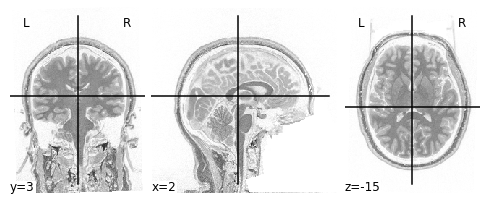

In [14]:
plot.plot_anat( img.math_img( '-a',a=t1 ) )

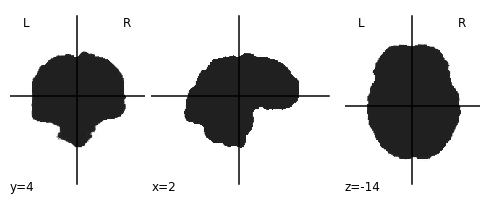

In [15]:
plot.plot_anat( img.math_img( '-a',a=bm) )

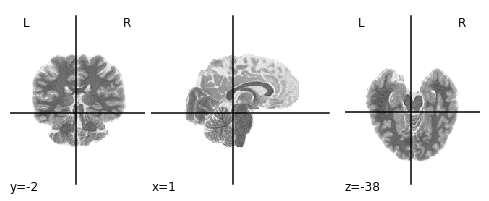

In [16]:
## remove skull
plot.plot_anat( img.math_img( '-a*b',a=t1, b=bm ) )

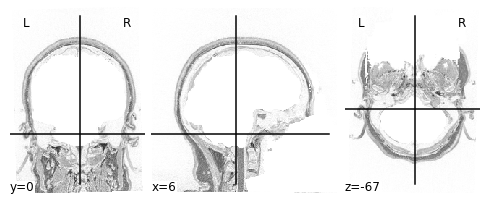

In [17]:
## remove brain keep skull
plot.plot_anat( img.math_img( '-a*(1-b)',a=t1, b=bm ) )

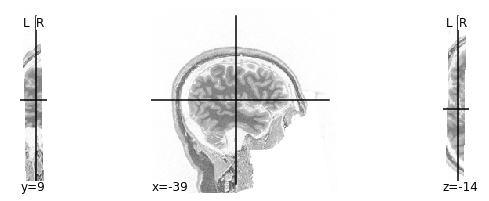

In [18]:
## show different slices
t1_img = img.load_img( t1 )
plot.plot_anat( img.math_img( '-a', a=t1_img.slicer[32:56, 16:-1, 16:-1] ) )

# 3. Combining T1 and functional

- loss of resolution; down sample T1 to match functional image 
- functional image is in 4D; 4th dimension is the time series sequence

- `plot.plot_epi` for functional image

In [19]:
subject = '10788'

st1z = layout.get(subject=subject, datatype='anat', suffix='preproc', extension='.nii.gz', 
                   space='MNI152NLin2009cAsym', return_type='file')
sbmz = layout.get(subject=subject, datatype='anat', suffix='brainmask', extension='.nii.gz', 
                   space='MNI152NLin2009cAsym',return_type='file')

ft1z = layout.get(subject=subject, datatype='func', suffix='preproc', extension='.nii.gz', 
                   space='MNI152NLin2009cAsym', return_type='file')
fbmz = layout.get(subject=subject, datatype='func', suffix='brainmask', extension='.nii.gz', 
                   space='MNI152NLin2009cAsym', return_type='file')

print( len( st1z), len( sbmz) , 
      len(ft1z), len(fbmz))

1 1 1 1


In [20]:
t1_mni_img = img.load_img( st1z[0] )
#t1_mask_img = img.load_img( sbmz[0] )
f_mni_img = img.load_img( ft1z[0] )
#f_mask_img = img.load_img( sbmz[0] )


T1 data - higher resolution - (193, 229, 193)


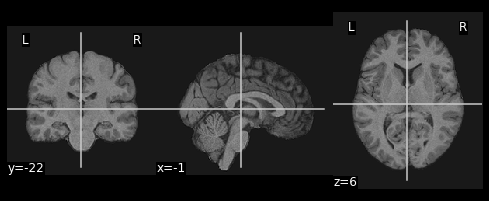

In [21]:
print('T1 data - higher resolution -', t1_mni_img.shape)
plot.plot_anat( t1_mni_img); 

Functional data - lower resolution - (65, 77, 49, 152)


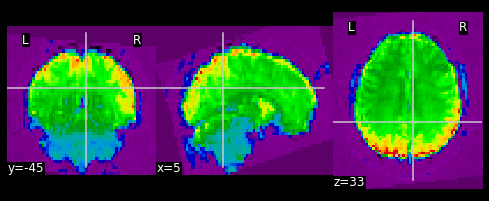

In [22]:
print('Functional data - lower resolution -', f_mni_img.shape)
plot.plot_epi( f_mni_img.slicer[:,:,:,0]);

(152,)


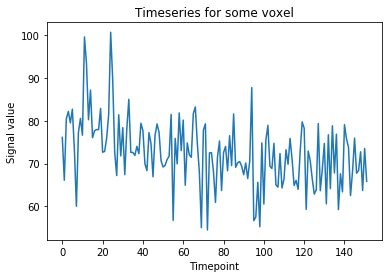

In [23]:
## Voxel time series
a_vox = f_mni_img.slicer[59:60, 45:46, 30:31, :].get_data()
a_vox = a_vox.flatten()
print(a_vox.shape )
plt.plot( np.arange(0, a_vox.shape[0]), a_vox)
plt.title('Timeseries for some voxel')
plt.xlabel('Timepoint')
plt.ylabel('Signal value');

### Downsampling T1 and Combine with Functional 

Resampling t1 - downsample to match functional. Then combine
T1 res:  (193, 229, 193)
Func res:  (65, 77, 49, 152)
Resampled T1 res:  (65, 77, 49)


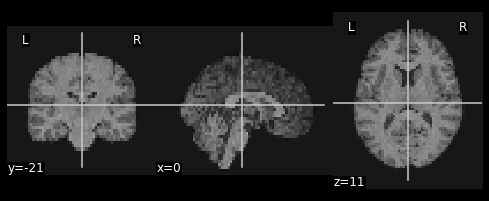

In [24]:
print("Resampling t1 - downsample to match functional. Then combine")

resampled_t1 = img.resample_to_img(t1_mni_img, 
                                   f_mni_img, 
                                   interpolation='continuous')

print( "T1 res: ", t1_mni_img.shape )
print( "Func res: ", f_mni_img.shape )
print( "Resampled T1 res: ", resampled_t1.shape )

plot.plot_anat( resampled_t1);

In [25]:
import matplotlib.animation
from IPython.display import HTML

In [26]:
%%capture
%matplotlib inline
fig, ax = plt.subplots()
def anim(img):
    plot.plot_anat(img, figure=fig, cut_coords=(0,0,0) )
    ax.set_facecolor('black')
ani = matplotlib.animation.FuncAnimation(
            fig, anim, frames=[t1_mni_img, resampled_t1]
        )


In [27]:
HTML(ani.to_jshtml())

# 4. Atlases

In [28]:
from nilearn import datasets, image as img, plotting as plot

#for inline visualization in jupyter notebook
%matplotlib inline

In [30]:
## Fetching an atlas
parcel_dir = '../resources/rois/' 
atlas_yeo_2011 = datasets.fetch_atlas_yeo_2011(parcel_dir)


Dataset created in ../resources/rois/yeo_2011



Downloaded 2637824 of ? bytes. ...done. (7 seconds, 0 min)
Extracting data from ../resources/rois/yeo_2011/a2fde1b0e3db25e49d233ec6cf6ada04/Yeo_JNeurophysiol11_MNI152.zip..... done.


In [31]:
atlas_yeo_2011.keys()

dict_keys(['description', 'thin_7', 'thick_7', 'thin_17', 'thick_17', 'colors_7', 'colors_17', 'anat'])

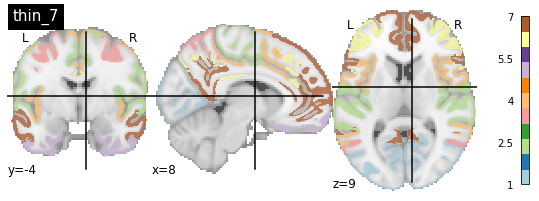

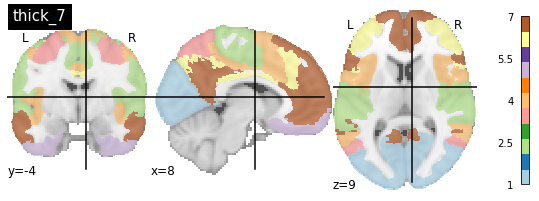

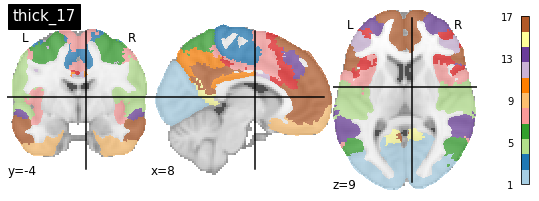

In [33]:
cut_coords = (8, -4 ,9)
colorbar=True
cmap = 'Paired'

plot.plot_roi(atlas_yeo_2011['thin_7'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thin_7')
plot.plot_roi(atlas_yeo_2011['thick_7'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thick_7')
plot.plot_roi(atlas_yeo_2011['thick_17'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='thick_17')

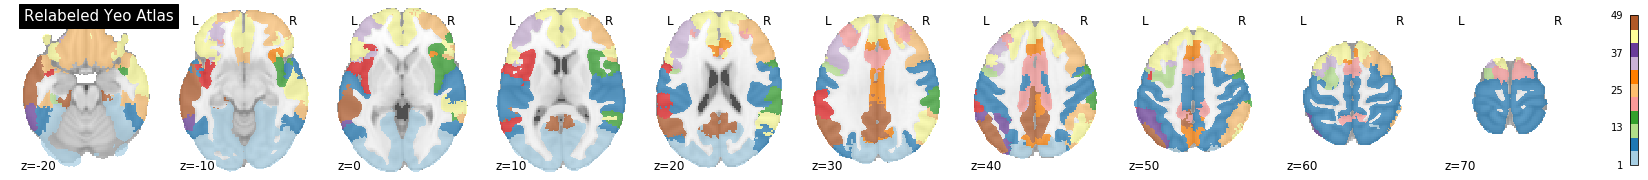

In [35]:
from nilearn.regions import connected_label_regions
atlas_yeo = atlas_yeo_2011['thick_7']
region_labels = connected_label_regions(atlas_yeo)
plot.plot_roi(region_labels,
              cut_coords=(-20, -10, 0, 10, 20, 30, 40, 50, 60, 70),
              display_mode='z',
              colorbar=True,
              cmap='Paired',
              title='Relabeled Yeo Atlas')

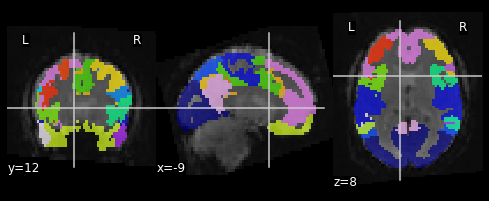

In [38]:
resampled_yeo = img.resample_to_img(region_labels, f_mni_img, interpolation = 'nearest')
plot.plot_roi(resampled_yeo, f_mni_img.slicer[:, :, :, 54])

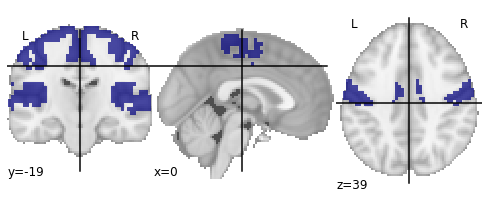

In [43]:
roi = 6
roi_mask = img.math_img('a == {}'.format(roi), a=resampled_yeo) 
masked_resamp_yeo = img.math_img('a*b',a=resampled_yeo,b=roi_mask) 
plot.plot_roi(masked_resamp_yeo)